<a href="https://colab.research.google.com/github/beulah-s/Cell_counting_Group1/blob/main/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python


In [ ]:
import cv2
import os
import pandas as pd
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import Dataset


In [ ]:
data_root = 'path'
print('The num of images is', len(os.listdir(data_root)))

label_path = 'path'
all_files = os.listdir(label_path)
csv_files = [f for f in all_files if f.endswith('.csv')]

labels = []

for csv_file in csv_files:
    csv_path = os.path.join(label_path, csv_file)
    df = pd.read_csv(csv_path)
    num_cells = df.shape[0]  # Number of cells
    labels.append(num_cells)


The num of images is 251


In [ ]:
class CellDataset(Dataset):
    def __init__(self, root_dir, labels, transform=None):
        self.root_dir = root_dir
        self.labels = labels
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.tiff')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]

        return image, label



def plot_cell(dataset, sample_id):
    """Displays the image corresponding to the sample ID"""
    image = dataset[sample_id][0]
    image = image.numpy().transpose((1, 2, 0))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def high_pass_filter_pil(img, kernel_size=11):
    img_np = np.array(img)

    # use low pass
    low_pass = cv2.GaussianBlur(img_np, (kernel_size, kernel_size), 0)

    # low pass filter
    high_pass = cv2.subtract(img_np, low_pass)

    return Image.fromarray(high_pass)



In [ ]:

transform = transforms.Compose([
    transforms.Resize((96, 96)),
    # transforms.Lambda(high_pass_filter_pil),
    # Resize the image to 64x64 pixels
    transforms.ToTensor(),  # Convert PIL Image to Tensor
#     transforms.RandomRotation(15),  # Randomly rotate the image by up to 30 degrees
#     transforms.RandomAffine(degrees=15, shear=15),  # Randomly distort the image
])

# transform = transforms.Compose([
#     # transforms.Resize((64, 64)),  # Resize the image to 64x64 pixels
#     transforms.ToTensor(),  # Convert PIL Image to Tensor
# ])

# Construct the dataset
dataset = CellDataset(root_dir=data_root, labels=labels, transform=transform)


In [ ]:
dataset

In [ ]:
from sklearn.model_selection import train_test_split

test_percent = 0.3
trainset, testset = train_test_split(dataset, test_size=test_percent, random_state=42)

print(len(trainset))
print(len(testset))

175
75


tensor([[0.0314, 0.0392, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
        [0.0392, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
        [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
        ...,
        [0.0549, 0.0471, 0.0431,  ..., 0.0392, 0.0392, 0.0392],
        [0.0980, 0.0667, 0.0431,  ..., 0.0392, 0.0353, 0.0392],
        [0.1294, 0.0824, 0.0431,  ..., 0.0353, 0.0353, 0.0353]])
torch.Size([96, 96])


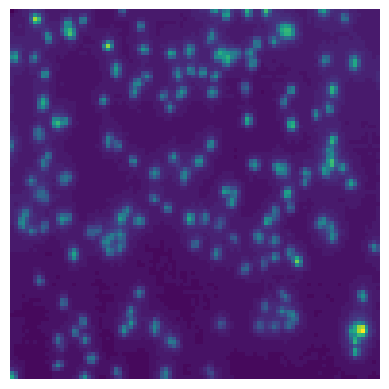

In [ ]:
first_img = dataset[0][0][0]

print(first_img)
print(first_img.shape)
plot_cell(dataset,0)

tensor([[0.0314, 0.0392, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
        [0.0392, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
        [0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
        ...,
        [0.0549, 0.0471, 0.0431,  ..., 0.0392, 0.0392, 0.0392],
        [0.0980, 0.0667, 0.0431,  ..., 0.0392, 0.0353, 0.0392],
        [0.1294, 0.0824, 0.0431,  ..., 0.0353, 0.0353, 0.0353]])
torch.Size([96, 96])


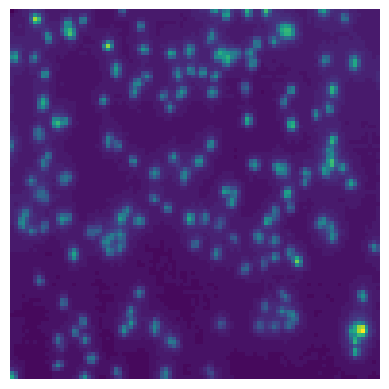

In [ ]:
first_img = dataset[0][0][0]

print(first_img)
print(first_img.shape)
plot_cell(dataset,0)

In [ ]:
#@title Define ResNet/VGG/MobileNet-V2
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
# import tensorflow as tf
import os


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):  # modified num_classes default to 1
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, 1)  # modified num_classes to 1

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        batch_size = out.shape[0]
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(batch_size, -1)
        out = self.linear(out)
        return out



class Block(nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, in_planes, out_planes, expansion, stride):
        super(Block, self).__init__()
        self.stride = stride

        planes = expansion * in_planes
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, groups=planes, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = out + self.shortcut(x) if self.stride==1 else out
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])  # removed num_classes argument








In [ ]:
model = ResNet18().cuda()

In [ ]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0)
epochs = 200
train_loader = DataLoader(trainset, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
loss_all = []
def train(model, train_loader, optimizer, epochs):
    loss_func = nn.L1Loss()
    for epoch in range(epochs):
        model.train()
        running_loss, n_batches = 0.0, 0

        for idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            # print('the pred is',outputs, labels)
            loss = loss_func(outputs, labels.float().view(-1,1))  # Ensure labels are float

            # print('the avg loss for one img is', loss/32)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            n_batches += 1

        loss = running_loss / n_batches
        loss_all.append(loss)
        print('Epoch %d training loss: %.3f' % (epoch, loss))


def test(model, test_loader):
    model.eval()
    test_loss = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images).view(-1, 1)  # Reshape the outputs tensor
            loss = nn.L1Loss()(outputs, labels.float().view(-1, 1))
            test_loss += loss.item() * images.size(0)
            total_samples += images.size(0)

    mean_loss = test_loss / total_samples
    print('Average Error of the network on the test set: %.2f' % (mean_loss))
    return mean_loss




In [ ]:
train(model, train_loader, optimizer, epochs)

Epoch 0 training loss: 193.842
Epoch 1 training loss: 190.324
Epoch 2 training loss: 187.437
Epoch 3 training loss: 185.554
Epoch 4 training loss: 184.008
Epoch 5 training loss: 182.548
Epoch 6 training loss: 181.150
Epoch 7 training loss: 179.918
Epoch 8 training loss: 178.858
Epoch 9 training loss: 177.668
Epoch 10 training loss: 176.524
Epoch 11 training loss: 175.403
Epoch 12 training loss: 174.320
Epoch 13 training loss: 173.156
Epoch 14 training loss: 172.053
Epoch 15 training loss: 170.917
Epoch 16 training loss: 169.837
Epoch 17 training loss: 168.793
Epoch 18 training loss: 167.760
Epoch 19 training loss: 166.733
Epoch 20 training loss: 165.708
Epoch 21 training loss: 164.648
Epoch 22 training loss: 163.606
Epoch 23 training loss: 162.561
Epoch 24 training loss: 161.547
Epoch 25 training loss: 160.449
Epoch 26 training loss: 159.321
Epoch 27 training loss: 158.466
Epoch 28 training loss: 157.595
Epoch 29 training loss: 156.501
Epoch 30 training loss: 155.662
Epoch 31 training 

In [ ]:
test(model, test_loader)

Average Error of the network on the test set: 187.64


187.6371307373047

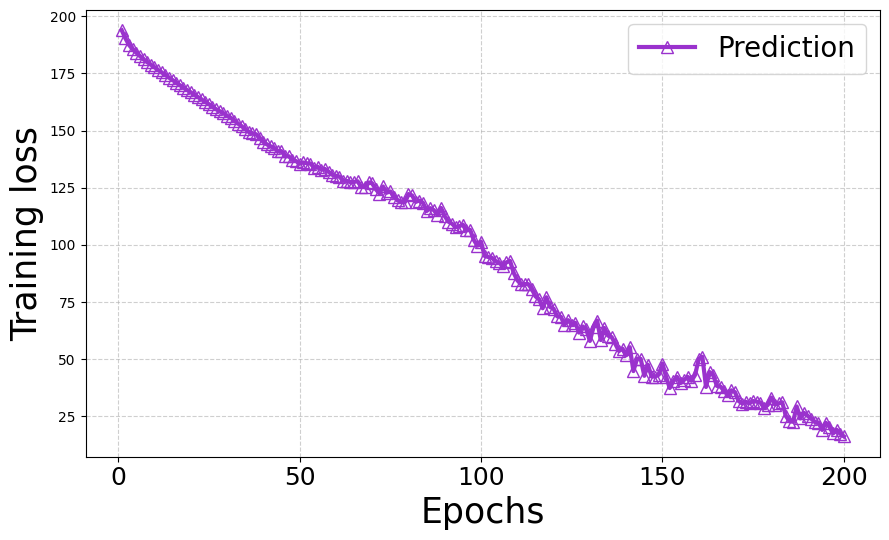

In [ ]:
loss_total = loss_all[:]
import matplotlib.pyplot as plt


x = list(range(1, 201))

plt.rcParams['figure.figsize'] = [9, 5.5]
fig, ax = plt.subplots()

ax.plot(x,loss_total, color ='#9A32CD', marker='^', linestyle='-', linewidth=3, markersize=8, fillstyle='none', label='Prediction')


ax.set_ylabel("Training loss", fontsize=25)
ax.set_xlabel('Epochs', fontsize=25)

ax.set_xticks([0,50,100,150,200])
ax.set_xticklabels(['0', '50', '100', '150', '200'], fontsize=18)


ax.legend(loc=1, prop={'size': 20})

ax.grid(True, linestyle='--', alpha=0.6)  # add gridlines

plt.tight_layout()
plt.savefig('ABL.pdf', dpi=300)
plt.show()


In [ ]:


class SuperCellDataset(Dataset):
    def __init__(self, root_dir, label_path, transform=None):
        self.root_dir = root_dir
        self.label_path = label_path
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.tiff')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # 1. Load image
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name)

        # 2. Randomly sample a 200x200 patch from the original image
        w, h = image.size
        left = np.random.randint(0, w - 200)
        upper = np.random.randint(0, h - 200)
        right = left + 200
        lower = upper + 200

        image = image.crop((left, upper, right, lower))

        # 3. Fetch corresponding csv
        csv_file = self.image_files[idx].replace('.tiff', '.csv')
        csv_path = os.path.join(self.label_path, csv_file)
        df = pd.read_csv(csv_path)

        # 4. Check how many cells are within the 200x200 patch
        num_cells = df[(df['X'] >= left) & (df['X'] <= right) &
                       (df['Y'] >= upper) & (df['Y'] <= lower)].shape[0]

        if self.transform:
            image = self.transform(image)

        return image, num_cells

# example
data_root = '/content/drive/MyDrive/CellCounts/IDCIA v2/images'
label_path = '/content/drive/MyDrive/CellCounts/IDCIA v2/ground_truth'

# construct patched dataset
superset = SuperCellDataset(data_root, label_path, transform=transform)

# get a single item
image, num_cells = superset[5]
print("Number of cells:", num_cells)


Number of cells: 48


In [ ]:
image

tensor([[[0.1451, 0.0824, 0.0549,  ..., 0.0431, 0.0431, 0.0392],
         [0.1255, 0.0745, 0.0510,  ..., 0.0431, 0.0431, 0.0392],
         [0.0902, 0.0588, 0.0510,  ..., 0.0431, 0.0431, 0.0392],
         ...,
         [0.0431, 0.0392, 0.0392,  ..., 0.1725, 0.1882, 0.2000],
         [0.0392, 0.0392, 0.0392,  ..., 0.1569, 0.1647, 0.1882],
         [0.0392, 0.0392, 0.0353,  ..., 0.1490, 0.1647, 0.2039]]])

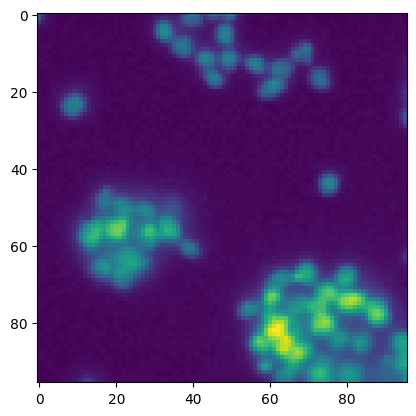

In [ ]:
plt.imshow(image.numpy().transpose(1, 2, 0))
plt.show()


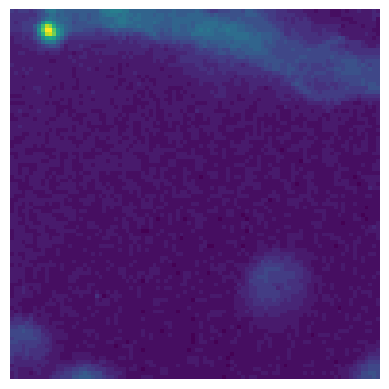

In [ ]:
plot_cell(superset,3)

In [ ]:
num_cells

48